In [2]:
#Imports and dependencies
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.visualization import plot_pointcloud
from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

['/home/alexis/Desktop/E3D', '/home/alexis/Desktop/E3D', '/home/alexis/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/alexis/Desktop/pytorch3d', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/alexis/.ipython']


In [2]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

In [3]:
#Download a couple meshes to work with
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2020-06-22 16:29:33--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘data/meshes/dolphin.obj.2’

dolphin.obj.2       100%[===================>] 153.09K   600KB/s    in 0.3s    

2020-06-22 16:29:34 (600 KB/s) - ‘data/meshes/dolphin.obj.2’ saved [156763/156763]

--2020-06-22 16:29:34--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/meshes/teapot.obj.2’

teapot.o

### Load Object

In [4]:
#Load the object without textures and materials
verts, faces_idx, _ = load_obj("data/meshes/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/alexis/Desktop/pytorch3d/pytorch3d/io/obj_io.py:70: UserWarning:

Faces have invalid indices



### Create a renderer

In [5]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=100, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras)
)

### ref - look_at_view_transform

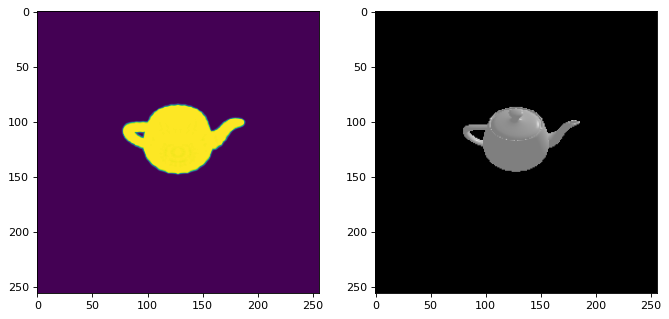

In [5]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### ref - look_at_rotation

In [6]:
# Position of the camera in world coordinates
x = 2.1
y = 3.4
z = 0.5
cam_posn = torch.from_numpy(np.array([x, y, z], dtype=np.float32))
#at - position of the object in world coordinates 
#up - vector of up direction in world coordinates
R = look_at_rotation(cam_posn[None, :], device=device)
T = -torch.bmm(R.transpose(1,2), cam_posn[None, :, None])[:, :, 0]

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T, camera)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

SyntaxError: positional argument follows keyword argument (<ipython-input-6-32d1c16c248d>, line 12)

In [1]:
Sphere(
    radius=2,
    num_points_theta = 1,
    num_points_phi =20,
    theta_min = math.pi/2,
    theta_max = math.pi/2, 
    phi_max = math.pi).plot()

SphericalSpiral(
    c = 6.5, 
    a = 1.5,
    t_min = math.pi,
    t_max=2*math.pi,
    num_points=1000).plot()


NameError: name 'Sphere' is not defined

### Camera Pose Trajectory and render

shaded


/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



{'mesh_name': 'teapot', 'images': {'shaded': [{'posn': 0, 'image_path': 'data/renders/teapot_2020-06-22T16:29:41/shaded/0_shaded.png', 'render_type': 'shaded', 'R': [[[0.45618972182273865, -0.3693389594554901, 0.8096170425415039], [0.6292420029640198, 0.7772095203399658, -9.914948796296643e-17], [-0.6292420029640198, 0.509445071220398, 0.5869585275650024]]], 'T': [[5.960464477539063e-08, 5.960464477539063e-08, 2.21652889251709]], 'extension': 'png'}, {'posn': 1, 'image_path': 'data/renders/teapot_2020-06-22T16:29:41/shaded/1_shaded.png', 'render_type': 'shaded', 'R': [[[0.4874061048030853, -0.31565818190574646, 0.8141223192214966], [0.6174282431602478, 0.7838773727416992, -0.06571614742279053], [-0.6174282431602478, 0.5346925854682922, 0.5769628882408142]]], 'T': [[-0.0, -0.0, 2.240183115005493]], 'extension': 'png'}, {'posn': 2, 'image_path': 'data/renders/teapot_2020-06-22T16:29:41/shaded/2_shaded.png', 'render_type': 'shaded', 'R': [[[0.5192869901657104, -0.2625942528247833, 0.81325

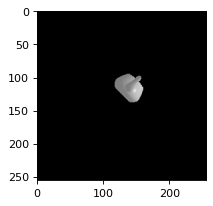

In [6]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

#Just to put these somewhere - this should be stored in param file after

def cam_trajectory_rotation(num_points: int = 40):
    """
    Returns: list of camera poses (R,T) from trajectory along a spherical spiral
    """
    
    #sphere = Sphere(
    #    radius=2,
    #    num_points_theta = 1,
    #    num_points_phi = 30,
    #    theta_min = math.pi/2,
    #    theta_max = math.pi/2, 
    #    phi_max = math.pi)
    shape = SphericalSpiral(
        c = 6.5,
        a = 1.5,
        t_min = math.pi,
        t_max=.0001*math.pi,
        num_points=num_points)
    up = torch.tensor([[0., 1., 1.]])
    R = []
    T = []
    for cp in shape._tuples:
        cp = torch.tensor(cp)
        R_new = look_at_rotation(cp[None, :],up=up, device=device)
        T_new = -torch.bmm(R_new.transpose(1,2), cp[None, :, None])[:, :, 0]
        if not len(R) and not len(T):
            R = [R_new]
            T = [T_new]
        else:
            R.append(R_new)
            T.append(T_new)
    return (R, T)

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [10, 50],
    azim_range: list= [-180, 180]):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.linspace(elev_range[0], elev_range[1], batch_size)
    azim = torch.linspace(elev_range[0], elev_range[1], batch_size)
    R = []
    T = []
    for e, a in elev, azim:
        R_new, T_new = look_at_view_transform(dist=dist, elev=e, azim=a)
        R = torch.stack((R, R_new)) if R else R_new
        T = torch.stack((T, T_new)) if T else T_new
    return (R, T)
    
def render_trajectory(cam_poses, write_gif=True):
    
    """
    output_folder = "./data/renders/"
    
    silhouette_output = join(output_folder, "camera_simulation_silhouette.gif")
    silhouette_writer = imageio.get_writer(silhouette_output, mode="I", duration=.2)
    
    image_output = join(output_folder, "camera_simulation_image.gif")
    image_writer = imageio.get_writer(image_output, mode="I", duration=.2)
    """
    render_manager = RenderManager(
        types=["shaded"],
        mesh_name = "teapot"
    )
    # Render the teapot providing the values of R and T.
    R, T = cam_poses
    for num in range(len(R)):
        #gl_cam = OpenGLPerspectiveCameras(device=device, R=R, T=T)
        #sf_cam = SfMPerspectiveCameras(device=device, R=R, T=T)
        #silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
        image_ref = phong_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
        
        #silhouette = silhouette.cpu().numpy()
        image_ref = image_ref.cpu().numpy()
        '''
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(silhouette.squeeze()[...,3])  # only plot the alpha channel of the RGBA image
        '''
        plt.grid(False)
        plt.subplot(1, 2, 2)
        plt.imshow(image_ref.squeeze())
        plt.grid(False)
        
        render_manager.add_images(
            num,
            {"shaded": image_ref.squeeze()}, 
            R[num], T[num])
        
    render_manager.close()
    return render_manager
    
cam_poses = cam_trajectory_rotation()
render = render_trajectory(cam_poses)

# Generate events from consecutive frames

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



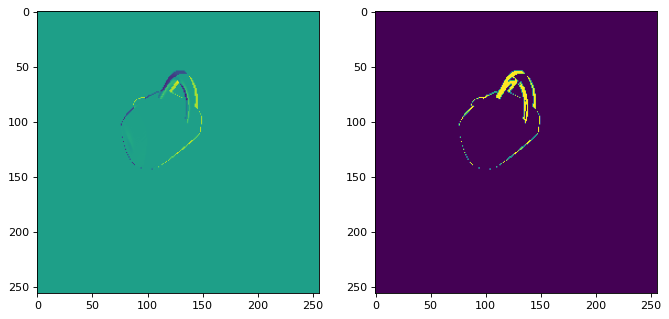

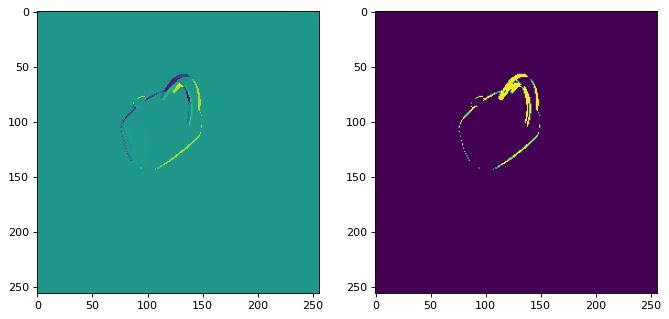

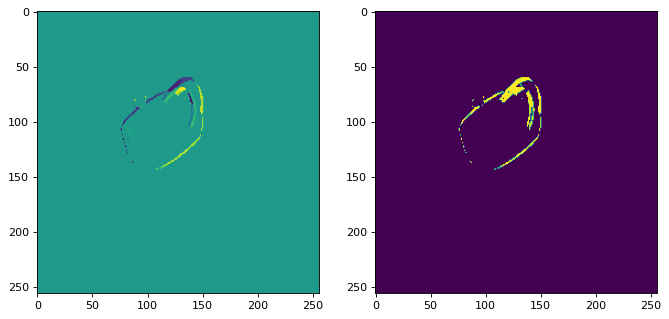

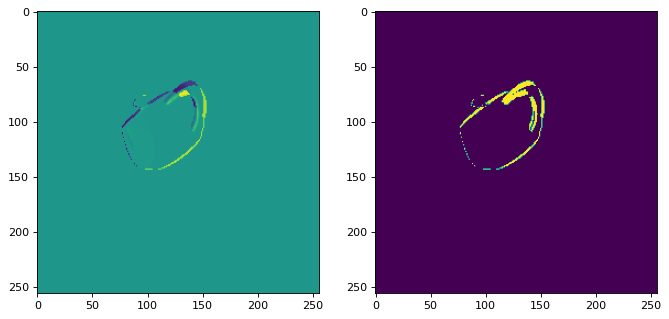

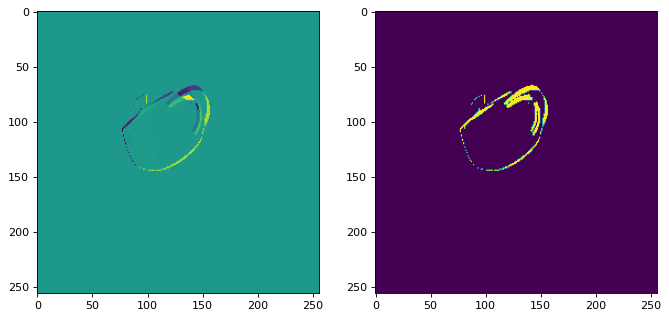

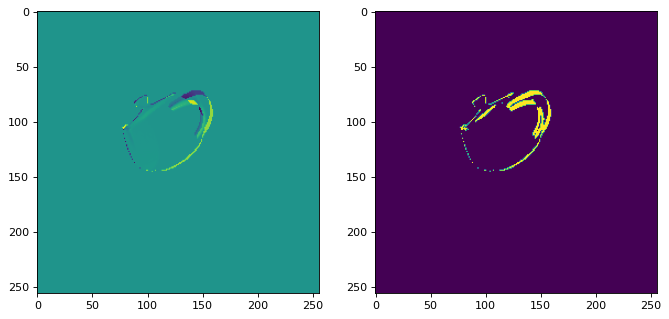

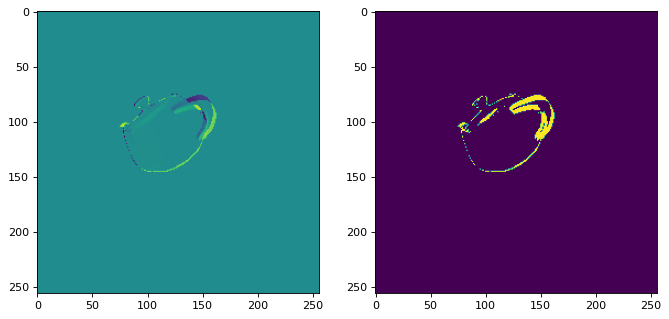

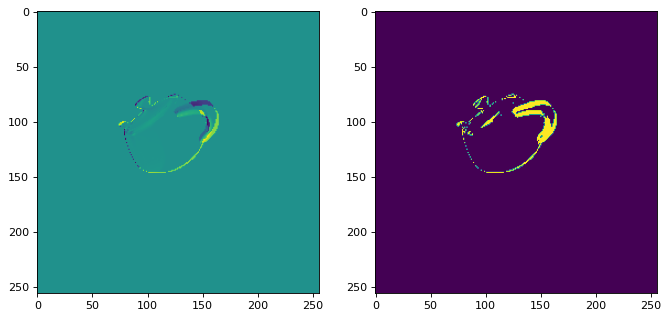

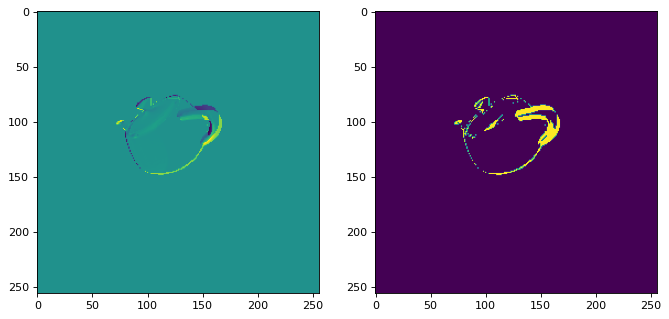

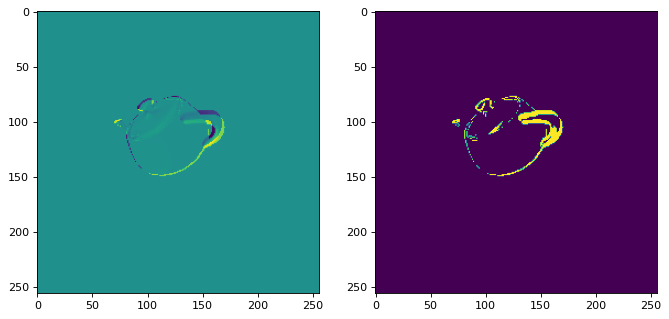

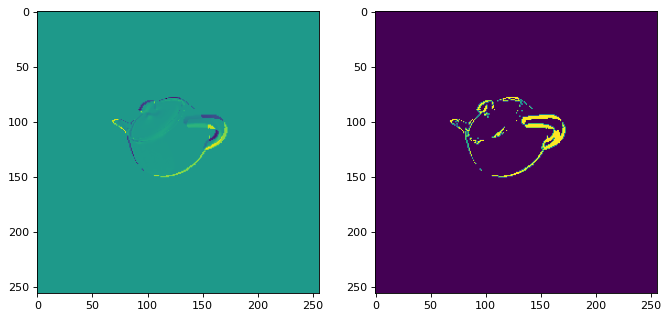

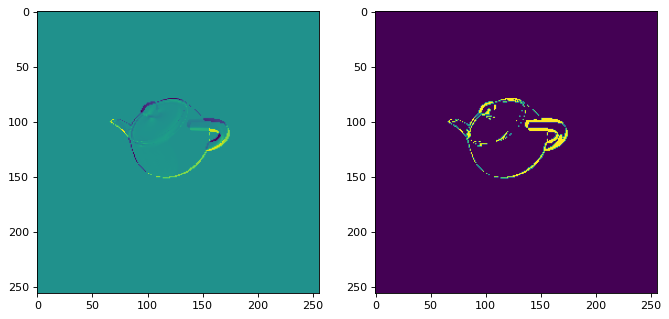

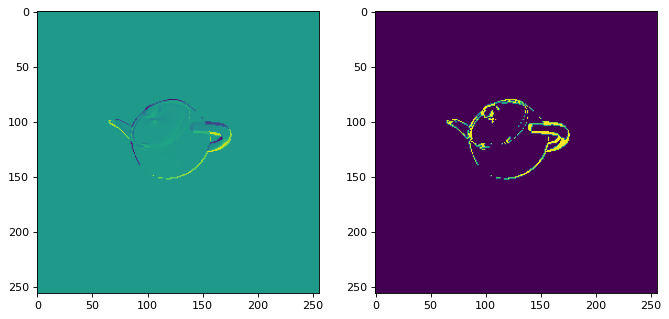

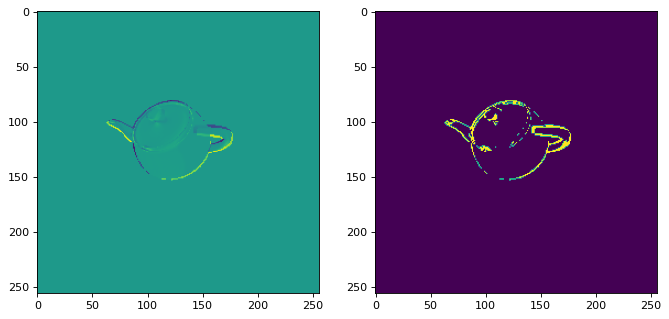

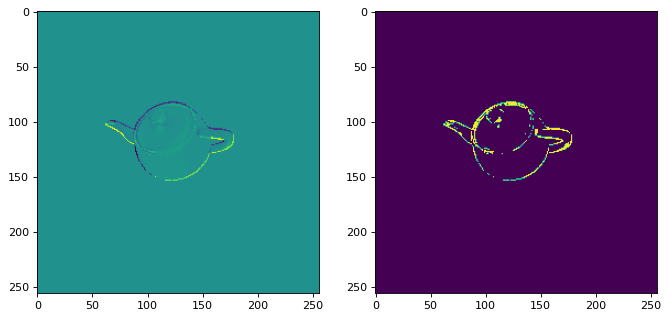

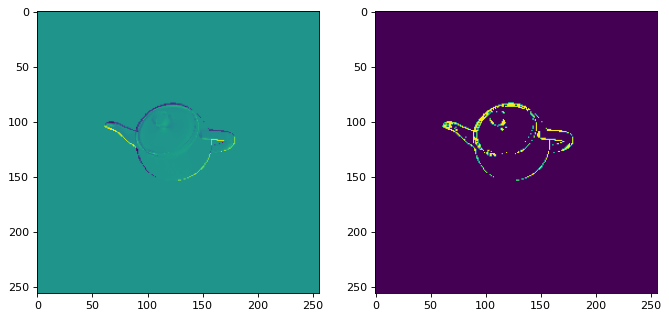

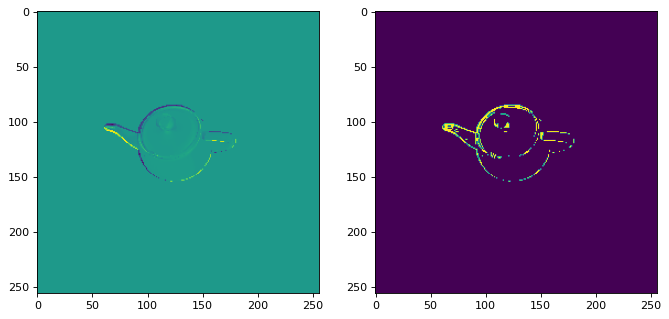

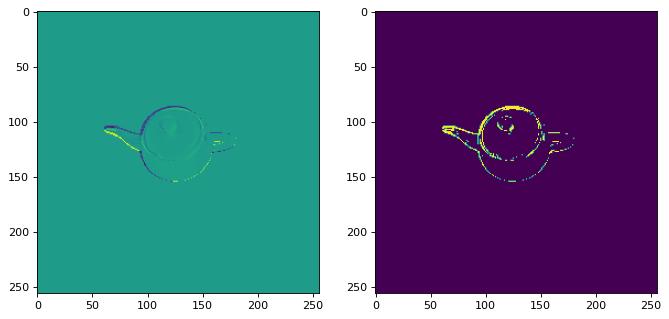

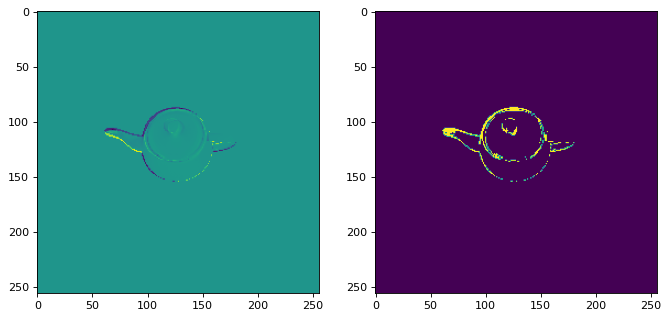

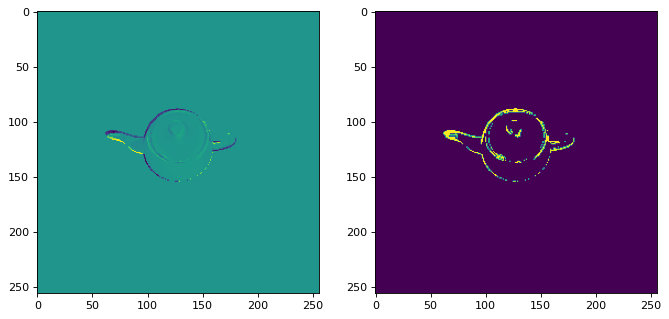

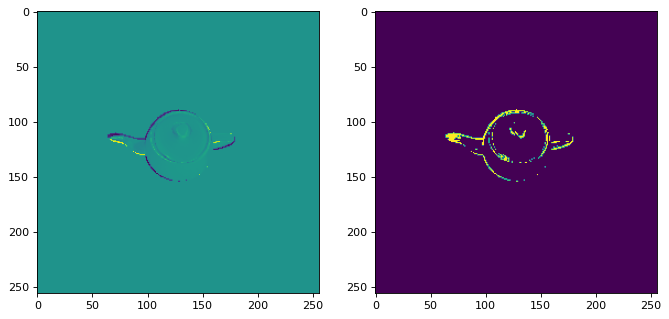

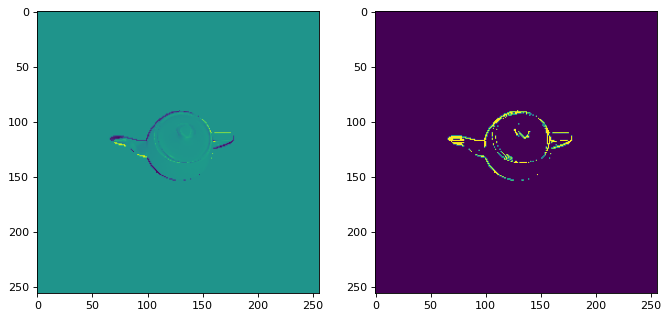

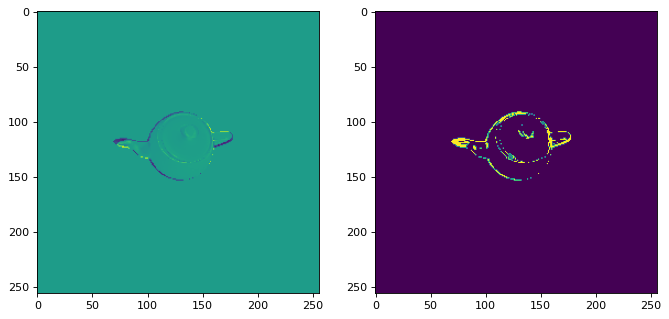

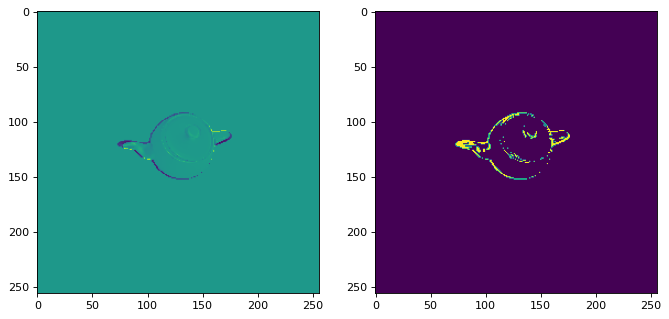

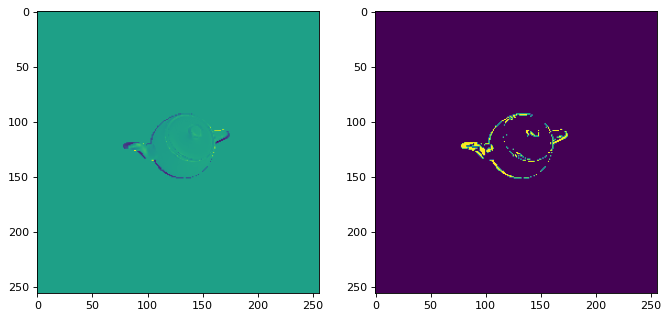

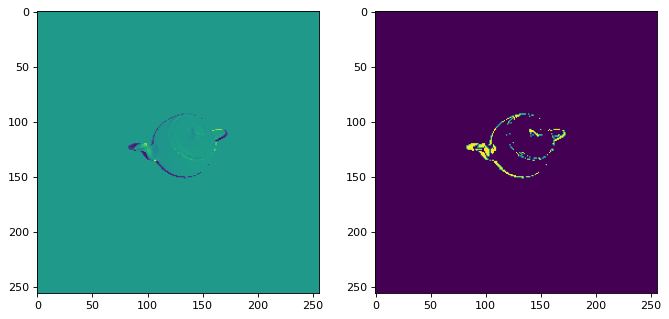

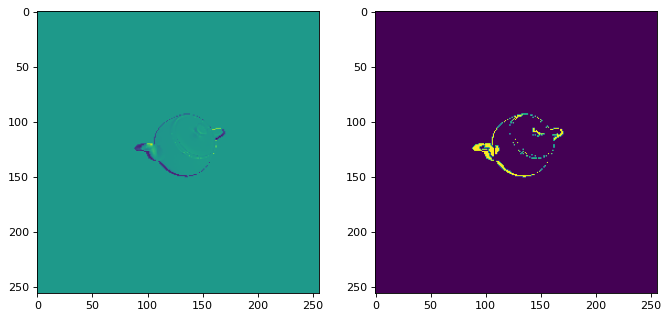

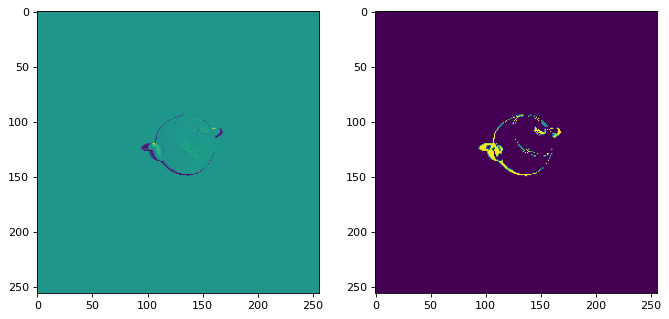

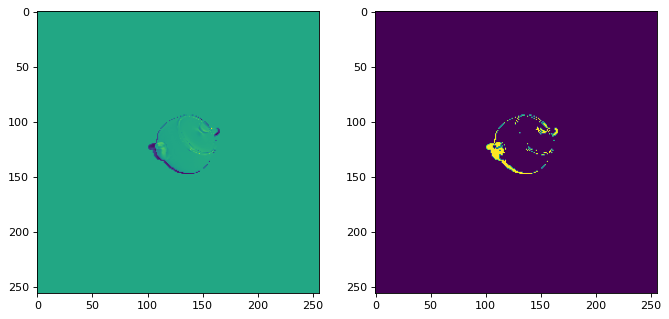

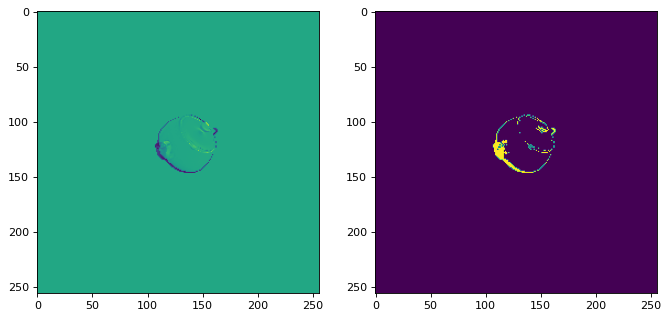

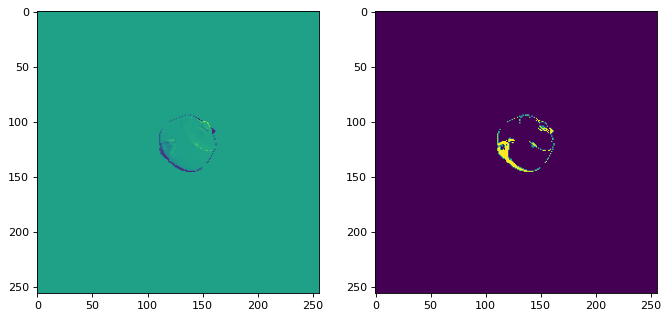

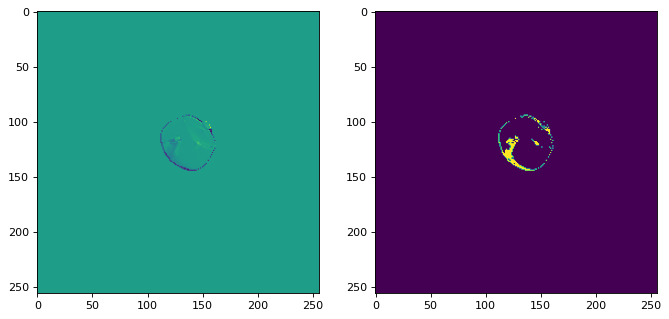

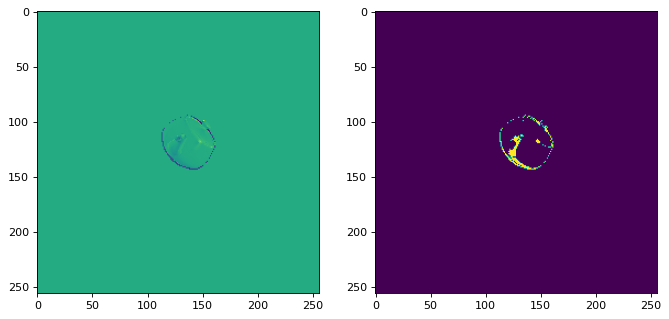

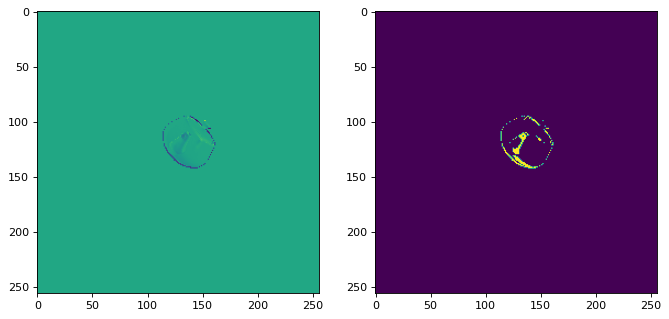

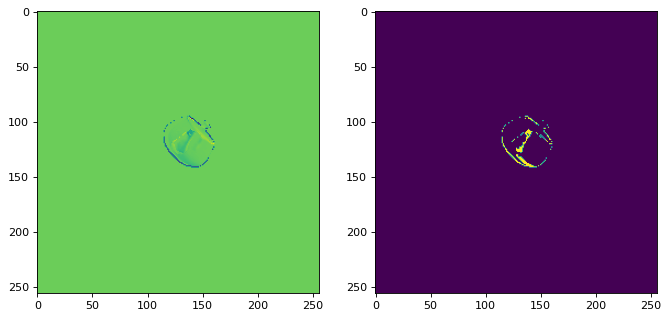

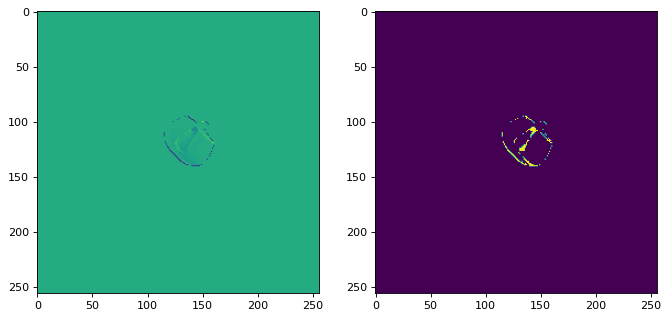

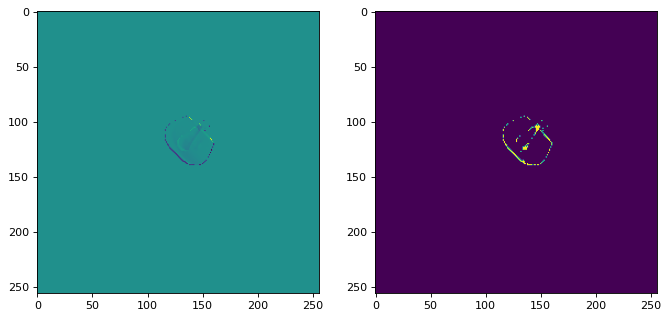

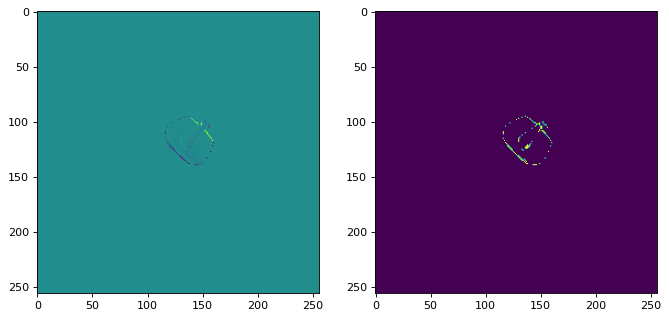

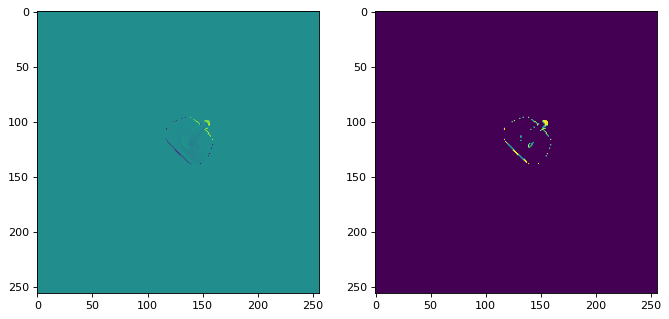

In [11]:
ON = 255
OFF = 0
threshold = 250

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def adaptive_thresholding(diff_frames):
    """
    Experiment: 
        Determine threshold from mean background illumination
    """
    raise NotImplementedError

def dilate_boundaries(diff_frame):
    """
    Experiment:
        Dilate the boundaries to introduce more noise on the outside
    """
    raise NotImplementedError

def fiter_consts(array_frame):
    const_filter = [float("nan"), float("inf")] #Just so we can extend this maybe?
    for const in const_filter:
        rows, cols = np.where(array_frame == const)

filename_output = "./gen_events.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=.2, loop=0)    

for type_key in render.images.keys():
    prev_img = None
    for num, img in enumerate(render.images[type_key]):
        img = deepcopy(img)
        img_manager = ImageManager.from_dict(img)        
        img_data = img_manager._load
        #if type_key == "shaded":
        #    img_data = rgb2gray(img_data)
        #else: continue
        if prev_img is not None:
            
            #if type_key == "shaded": print(np.where(img_data!=prev_img))
            
            
            diff_frames = np.subtract(img_data, prev_img)
            #if type_key == "shaded": 
                #Plt imshow should only take in a uint8
            #    diff_frames = np.uint8(diff_frames)
            
            #diff_frames[:,:,-1].shape) - only take first two dims of the array
            #if type_key == "shaded": print(np.where(diff_frames!=0))
                
            threshold_diff = (diff_frames < threshold) * diff_frames
            #threshold_diff = np.where(diff_frames > threshold, 1, 0) #This sets the entire array to 1 or 0
            
            tanh_diff = np.tanh(threshold_diff).astype(np.uint8)
            tanh_diff = np.where(tanh_diff != 0, ON, OFF) #Set the pixels to on or off based off of their value
            
            #Matplot plotting
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(diff_frames) 
            plt.grid(False)
            plt.subplot(1, 2, 2)
            plt.imshow(tanh_diff)
            plt.grid(False)
            
            image = img_as_ubyte(tanh_diff)
            writer.append_data(image)
            """
            #Plotly plotting - this doesn't work
            fig = make_subplots(rows=1, cols=2)
            fig.add_trace(
                px.imshow(diff_frames),
                row = 1, col = 1
            )
            fig.add_trace(
                px.imshow(tanh_diff),
                row=1, col=2
            )
            fig.show()
            """
        prev_img = img_data
writer.close()
        
        

## Test model

In [59]:
class ImageBasedDifferentiableModel(nn.Module):
    
    def __init__(self, render, renderer, device):
        super().__init__()

        #Store stuff
        self.device = device
        self.renderer = renderer
        
        #Load images from the render
        #trajectory = [R, T] where R & T are (N,3)
        trajectory = render._trajectory
        self.R, self.T = trajectory
        #images = np.array([img1, img2]) where img is (256, 256)
        self.images_gt = render._images()
        
        #Register to the buffer
        #self.register_buffer('trajectory', trafjectory)
        #self.register_buffer('images', images)
        
        #Create a source mesh
        self.src_mesh = ico_sphere(4, device)
        deform_verts = torch.full(self.src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        #Create an optimizable parameter for the mesh
        self.mesh = nn.Parameter(deform_verts)
        
    def forward(self):
        #Offset the mesh
        mesh_buffer = self.src_mesh.offset_verts(self.mesh)
        #sample_pts = sample_points_from_meshes(mesh_buffer, 5000)
        plot_pointcloud(mesh_buffer)
        #r = torch.index_select(self.R, 0, torch.tensor([0]))
        #print(r, r.shape)
        #t = torch.index_select(self.T, 0, torch.tensor([0]))
        #print(t, t.shape)
        #render_mesh = self.renderer(mesh_buffer, device = self.device, R=r, T =t)
        #plt.imshow(render_mesh.cpu().numpy())
        
        ##BATCH Project 3D mesh to 2D ##
        batch_size = len(self.images_gt)
        mesh_buffer.extend(batch_size)
        #Create a batch of cameras
        cameras = SfMPerspectiveCameras(device=self.device, R=self.R, T=self.T)
        #cameras = OpenGLOrthographicCameras(device=self.device, R=self.R, T=self.T)
        projections = self.renderer(mesh_buffer, device=self.device, cameras=cameras)
        
        
        #Calculate loss of each image
        #Other things to try: I
        loss = torch.tensor()
        for idx in batch_size:
            projection = projections[idx][..., 3]
            image_gt = self.images_gt[idx]
            img_diff = torch.sum((projection - image_gt) ** 2)
            loss = torch.cat((loss, img_diff), 0)
        loss = torch.mean(loss)
        
        return loss, projections[0]
    

In [60]:
# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = ImageBasedDifferentiableModel(render, phong_renderer, device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) #Hyperparameter tuning

In [61]:
loop = tqdm_notebook(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



NameError: name 'np' is not defined